# Data

In [1]:
J = 8
y = [28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]
σ = [15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]
schools = [
    "Choate",
    "Deerfield",
    "Phillips Andover",
    "Phillips Exeter",
    "Hotchkiss",
    "Lawrenceville",
    "St. Paul's",
    "Mt. Hermon"
];

nwarmup, nsamples, nchains = 1000, 1000, 4;

# Soss

In [2]:
using Soss, NamedTupleTools

In [3]:
using Distributions

struct Simulator
    mu
end

Base.rand(sim::Simulator) = rand(Normal(sim.mu, 1))

simulihood = Soss.@model (mu) begin
    mu2 ~ Normal(mu, 1)
    x ~ Simulator(mu2)
end

@model mu begin
        mu2 ~ Normal(mu, 1)
        x ~ Simulator(mu2)
    end


In [4]:
struct NotNormal
    sigma
end

foo = Soss.@model (sigma) begin
    X ~ NotNormal(sigma)
end

@model sigma begin
        X ~ NotNormal(sigma)
    end


In [5]:
Soss.sourceXform(foo)

quote
    _result = NamedTuple()
    X = rand(NotNormal(sigma))
    _t = xform(NotNormal(sigma), _data)
    _result = merge(_result, (X = _t,))
    (TransformVariables.as)(_result)
end

In [6]:
rand(simulihood(mu = 10))

(mu2 = 12.309942428866353, x = 12.126931264456756)

## Currying

To understand the idea behind Soss models, we first introduce the concept of currying. The basic idea of currying is to convert a multivariate function into an equivalent function composed of univariate functions.

In [7]:
myplus(x, y) = x + y
mycurriedplus = x -> (y -> y + x)

#7 (generic function with 1 method)

## Modeling joint distributions using Soss

The goal of Bayesian data analysis is to come up with a plausible explanation for some phenomenon or data in the form of a joint distribution. Defining complicated multivariate distributions outright is extremely difficult, so statistician typically decompose the task into defining conditional distributions and place independence assumptions on the interactions between the random variables.

## Free and bound variables in a statistical model

For a given data analysis task a statistician will need to decide a model fully. A fully defined model does not have any free parameters , so we can readily sample data from it using a computer. Some classes of models, such as linear regression, are used in many different contexts, so it is useful be able to define models where we can define new models easily simply by assigning new values to the parameters of a model. In this case the unbounded parameters in the model are called free parameters.


## Template for defining Soss models

A Soss model is defined by using the `model` macro. A macro is simply a piece of code that can modify code. While macros are an extremely powerful concept, they can be used to produce unexpected behaviour, so we prepend their use with the @ sign to make their use clear.

```julia
name_of_the_model = @model (unbound, parameters) begin
    # Define your model here
end
```

## Using Soss models

Once we have defined a model, we can assign values to the unbound parameters to define a joint distribution. Assigning values can be just like calling a function with keyword arguments. Once all the parameters are bound, we have a fully defined joint distribution, which we can sample from.

## Model syntax

From mathematical notation to Soss models. Soss syntax is designed to resemble mathematical notation for statistical models.

## Univariate random variables

The typical notation $X \sim Normal(\mu, \sigma)$, translates directly to Soss. The objects on the right hand side must implement a `rand` method.

## Independent and identically distributed random variables

It is common to assume that a collection of random variables are independent and identically distributed. This is commonly abbreviated as `iid`. In Soss, we declare the iid assumption using the `iid` function. It takes as argument the length of the random vector, for which we are making the iid assumption. For example, we could assume 10 iid standard Normal distributions using

```julia
N = 10
iid(10)(Normal(0, 1))
```

It is typical to use the pipe operator `|>` to make the syntax nicer.

```julia
N = 10
Normal(0, 1) |> iid(N)
```

## Loops

To model a random vector, where the components depend on the index, we use loops. In Soss we use the `For` operator. The first argument is a function, which maps the index of a random vector to an expression of the component.

```julia
For(j -> Normal(theta[j], sigma[j]), 1:J)
```

It is typical to use Julia's `do` shorthand for defining loops.

```julia
For(1:J) do j
    Normal(θ[j], σ[j])
end
```

# Using a Soss model in the Bayesian workflow

A joint distribution defined in Soss can be used to perform useful model transformations. Probably the most important from a practical statistician point of view is obtaining the prior predictive and posterior predictive distributions.

## The prior predictive distribution

The subjective nature of the prior distributions is one of the key points of controversy. There is a vast literature on the philosophy and practical application of different choices of prior distributions.

Perhaps due to the controversies associated with the prior distribution, the likelihood function and the prior distribution have historicallyt been treated separately. [] argues that the prior can only be understood in the context of a likelihood function.

Assigning numerical values to the hyperparameters is difficult when there is no context. This task becomes much easier when we inspect the implications that our choices of prior parameters place on our joint distribtion.

By defining families of joint distributions, Soss models make it easy to investigate how different choices of prior parameters affect our model.

The goal of the prior predictive analysis is to rule out values of the hyperparameters that result in obviously wrong data while still providing coverage for plausible values.

## MCMC

Solving Baeysian data analysis typically boil down to problems involving means of probability distributions. We remind the reader of the definition here. For a random variable $X$ defined on a domain $D$ with a probability distribution $p$, we can find the expectation of a function involving $X$, via the integral

$$
    E[f(X)] = \int_{D} f(x)p(x) \, dx
$$

As anyone who has taken caclulus knows solving integrals can get quite tricky. One dimensional integrals are difficult enough, but things become even difficult in higher dimensions.

Fortunately, we can use computer to estimate integrals of this form quite efficiently. The key idea is to get a representative sample from the random variable $X$ and estimate the mean numerically based on this sample.

####  Sampling values from a distribution

So, how do we go about sampling values from a distribution? Random walk metropolis hastings

### Exploiting knowledge about the distribution to sample more efficiently

Hamiltonian monte carlo

In [8]:
mod = Soss.@model (J, σ) begin
    μ ~ Normal(0, 5)
    τ ~ HalfCauchy(5)
    θ ~ Normal(μ, τ) |> iid(J)
    y ~ For(1:J) do j
        Normal(θ[j], σ[j])
    end
end

constant_data = (J = J, σ = σ)
param_mod = mod(; constant_data...)

Joint Distribution
    Bound arguments: [J, σ]
    Variables: [τ, μ, θ, y]

@model (J, σ) begin
        τ ~ HalfCauchy(5)
        μ ~ Normal(0, 5)
        θ ~ Normal(μ, τ) |> iid(J)
        y ~ For(1:J) do j
                Normal(θ[j], σ[j])
            end
    end


In [9]:
sourceWeightedSample(mod)

quote
    _ℓ = 0.0
    τ = rand(HalfCauchy(5))
    μ = rand(Normal(0, 5))
    θ = rand(Normal(μ, τ) |> iid(J))
    y = rand(For(1:J) do j
                #= In[8]:6 =#
                Normal(θ[j], σ[j])
            end)
    return (_ℓ, (J = J, σ = σ, μ = μ, τ = τ, θ = θ, y = y))
end

In [10]:
arguments(param_mod)

(J = 8, σ = [15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [11]:
param_mod.model

@model (J, σ) begin
        τ ~ HalfCauchy(5)
        μ ~ Normal(0, 5)
        θ ~ Normal(μ, τ) |> iid(J)
        y ~ For(1:J) do j
                Normal(θ[j], σ[j])
            end
    end


In [12]:
Set(variables(mod))

Set{Symbol} with 6 elements:
  :μ
  :σ
  :J
  :y
  :τ
  :θ

In [13]:
setdiff(parameters(mod), [:y])

3-element Array{Symbol,1}:
 :μ
 :τ
 :θ

In [14]:
isinf(typemax(Int64))

false

In [15]:
arguments(mod)

2-element Array{Symbol,1}:
 :J
 :σ

In [16]:
mod(; constant_data...)()

MethodError: MethodError: no method matching (::Soss.JointDistribution{NamedTuple{(:J, :σ),Tuple{Int64,Array{Float64,1}}},NamedTuple{(:J, :σ),T} where T<:Tuple,TypeEncoding(begin
    τ ~ HalfCauchy(5)
    μ ~ Normal(0, 5)
    θ ~ Normal(μ, τ) |> iid(J)
    y ~ For(1:J) do j
            Normal(θ[j], σ[j])
        end
end),TypeEncoding(Main)})()
Closest candidates are:
  Any(!Matched::NamedTuple) at /home/kusti/.julia/dev/Soss/src/core/jointdistribution.jl:11

## Sampling from a model

In [17]:
rand(param_mod)

(τ = 4.113735795147721, μ = -3.0149612683756253, θ = [-2.4357562912611446, -8.450760942754055, -2.8233942630989812, -4.869445303088138, -7.0454432655681, -14.520588263391739, -4.349659317740904, -4.184376383198362], y = [10.731529304559755, 4.132186976509306, 20.8251708092931, -10.215582743934327, -11.658630569575156, -8.407889028068585, -3.420581591988563, -10.728509003171066])

## Sampling from the posterior

In [18]:
post = map(1:nchains) do _
    dynamicHMC(param_mod, (y = y,), nsamples)
end;

In [19]:
post[2][2]

(:treedepth => [5, 4, 4, 4, 5, 5, 4, 3, 3, 4  …  4, 4, 5, 4, 4, 4, 5, 5, 6, 3], :divergent => Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], :energy => [55.66941194968842, 66.6798430233682, 64.44665202985317, 61.966900739041726, 62.00506939761171, 61.953726638109536, 59.12025814042221, 54.95657875702234, 54.59982988628579, 58.18263389628212  …  59.11890538324652, 57.27645328336733, 62.24983261525727, 60.760594413763855, 59.653636932049096, 64.305124375873, 64.284902864755, 61.65971750903316, 62.79284466369427, 60.707863744074686])

In [20]:
apost = advancedHMC(param_mod, (y=y,), nsamples)

([[-0.5205130258190899, -0.8181908174045915, 1.3688307121185124, 1.0952888658760866, -0.9947026676730574, -0.8501657220944207, 1.0406558260960672, -0.054845257056080586, -0.8385269076546882, -0.34650344293195207], [-0.5205130258190899, -0.8181908174045915, 1.3688307121185124, 1.0952888658760866, -0.9947026676730574, -0.8501657220944207, 1.0406558260960672, -0.054845257056080586, -0.8385269076546882, -0.34650344293195207], [1.1834735280058257, 1.814688026879197, -1.6347878417045512, -1.1603333392628625, 0.6393589714620576, -0.3956360373706631, -2.4020915464772976, -1.6184848107951504, 0.928464280358736, -2.9555418403783715], [1.365771325963549, -1.061127426594659, 3.729713009318358, 2.2881212888417397, 1.667282210630563, 2.792368872795553, -0.7831402264102992, 0.9670267342222261, 3.1279877891200614, 3.7743468006918994], [0.35181832045078043, 2.498238204689897, 2.5711048606340072, -0.02540241452538118, 4.240569576909472, 2.9744197819596003, 1.4264286253330485, -0.4159351296914465, 4.3170

In [21]:
apost[1]

1000-element Array{Array{Float64,1},1}:
 [-0.5205130258190899, -0.8181908174045915, 1.3688307121185124, 1.0952888658760866, -0.9947026676730574, -0.8501657220944207, 1.0406558260960672, -0.054845257056080586, -0.8385269076546882, -0.34650344293195207]
 [-0.5205130258190899, -0.8181908174045915, 1.3688307121185124, 1.0952888658760866, -0.9947026676730574, -0.8501657220944207, 1.0406558260960672, -0.054845257056080586, -0.8385269076546882, -0.34650344293195207]
 [1.1834735280058257, 1.814688026879197, -1.6347878417045512, -1.1603333392628625, 0.6393589714620576, -0.3956360373706631, -2.4020915464772976, -1.6184848107951504, 0.928464280358736, -2.9555418403783715]
 [1.365771325963549, -1.061127426594659, 3.729713009318358, 2.2881212888417397, 1.667282210630563, 2.792368872795553, -0.7831402264102992, 0.9670267342222261, 3.1279877891200614, 3.7743468006918994]
 [0.35181832045078043, 2.498238204689897, 2.5711048606340072, -0.02540241452538118, 4.240569576909472, 2.9744197819596003, 1.426428

## Ideal API

```julia
mymodel = @model (mu, sigma) begin
    # Stuff
end

prip = prior_predictive(mymodel)
post = posterior(mymodel, data)
popre = posterior_predictive(mymodel, data, posterior_samples)
popre2 = posterior_predictive(mymodel, data)

sample(prip, args...)
fit(Normal, posterior)
fit([:mu => Normal], posterior)

struct EmpiricalDistribution end

```

## ABC

### Particle based

```julia
prip = prior_predictive(mymodel, penalty(theta, data))
post = posterior(mymodel, data, penalty(theta, data))
```

### Surrogate models
```julia
fit(GP, simulator, data, penalty)
fit(Gaussian, simulator, data, summary_statistics)
fit(LikelihoodRatio(summary_statistics), simulator, data)
```

### Inference compilation
```julia
fit(NeuralNetwork, model)
```

## Posterior predictive

In [22]:
keys(param_mod.model.dists)

(:μ, :τ, :θ, :y)

In [23]:
param_mod.model.args

2-element Array{Symbol,1}:
 :J
 :σ

In [24]:
#struct PosteriorPredictive
#    nchains :: Int
#    nsamples :: Int
#end
#
#function posterior_predictive(model, data, posterior_samples)
#    parameters = difference(variables(model), columns(data))
#    pred = predictive(model, parameters...)
#    post_postpred = map(posterior_samples) do post_draws
#        map(post_draws) do post_draw
#            pred_draw = rand(pred(post_draw))
#            pred_draw = delete(pred_draw, keys(constant_data))
#            return merge(pred_draw, post_draw)
#        end
#    end
#end
#
#function (pp::PosteriorPredictive)(model, data)
#    posterior_samples = map(1:nchains(pp)) do _
#        #TODO: Generalize samplers
#        dynamicHMC(model, data, nsamples(pp))
#    end
#end
#
#
#
#pred = predictive(mod, :μ, :τ, :θ)
#post_postpred = map(post) do post_draws
#    map(post_draws) do post_draw
#        pred_draw = rand(pred(post_draw))
#        pred_draw = delete(pred_draw, keys(constant_data))
#        return merge(pred_draw, post_draw)
#    end
#end;

In [25]:
using ArviZ

plot_rank(post; var_names = ["μ", "τ"]);
#gcf()

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/kusti/.julia/packages/PyCall/zqDXB/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Can only convert xarray dataarray, xarray dataset, dict, netcdf filename, numpy array, pystan fit, pymc3 trace, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not list')
  File "/home/kusti/.julia/conda/3/lib/python3.7/site-packages/arviz/data/converters.py", line 133, in convert_to_inference_data
    ", ".join(allowable_types), obj.__class__.__name__


In [26]:
idata = from_namedtuple(
    post_postpred;
    posterior_predictive = [:y],
    prior = prior_priorpred,
    prior_predictive = [:y],
    observed_data = (y = y,),
    constant_data = constant_data,
    coords = Dict("school" => schools),
    dims = Dict(
        "y" => ["school"],
        "σ" => ["school"],
        "θ" => ["school"],
    ),
    library = Soss,
)

UndefVarError: UndefVarError: prior_priorpred not defined

In [27]:
plot_density(
    [idata.posterior_predictive, idata.prior_predictive];
    data_labels = ["Post-pred", "Prior-pred"],
    var_names = ["y"],
)
gcf()

UndefVarError: UndefVarError: idata not defined

# Stan

In [28]:
using CmdStan, MCMCChains

schools_code = """
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}

generated quantities {
    vector[J] log_lik;
    vector[J] y_hat;
    for (j in 1:J) {
        log_lik[j] = normal_lpdf(y[j] | theta[j], sigma[j]);
        y_hat[j] = normal_rng(theta[j], sigma[j]);
    }
}
"""

schools_dat = Dict("J" => J, "y" => y, "sigma" => σ)
stan_model = Stanmodel(
    model = schools_code,
    name = "schools",
    nchains = nchains,
    num_warmup = nwarmup,
    num_samples = nsamples,
    output_format = :mcmcchains,
    random = CmdStan.Random(8675309),
)
_, stan_chns, _ = stan(stan_model, schools_dat, summary = false);

ArgumentError: ArgumentError: Package CmdStan not found in current path:
- Run `import Pkg; Pkg.add("CmdStan")` to install the CmdStan package.


# Turing

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/kusti/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling:   0%|                                         |  ETA: 0:03:09┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/kusti/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling:  44%|██████████████████▎                      |  ETA: 0:00:01┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/kusti/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


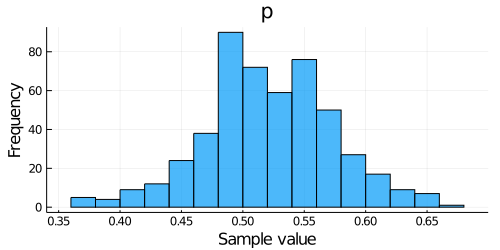

In [29]:
# Import libraries.
using Turing, StatsPlots, Random

# Set the true probability of heads in a coin.
p_true = 0.5

# Iterate from having seen 0 observations to 100 observations.
Ns = 0:100;

# Draw data from a Bernoulli distribution, i.e. draw heads or tails.
Random.seed!(12)
data = rand(Bernoulli(p_true), last(Ns))

# Declare our Turing model.
Turing.@model coinflip(y) = begin
    # Our prior belief about the probability of heads in a coin.
    p ~ Beta(1, 1)

    # The number of observations.
    N = length(y)
    for n in 1:N
        # Heads or tails of a coin are drawn from a Bernoulli distribution.
        y[n] ~ Bernoulli(p)
    end
end;

# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 1000
ϵ = 0.05
τ = 10

# Start sampling.
chain = sample(coinflip(data), NUTS(), iterations);

# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

In [30]:
using ArviZ

In [31]:
ArviZ.chains_to_dict(chain)

Dict{String,Array} with 1 entry:
  "p" => [0.513994 0.515415 … 0.581376 0.494917]

In [32]:
chain

Object of type Chains, with data of type 500×13×1 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = p

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
           p  0.5210  0.0527    0.0024  0.0030  518.3490  1.0021

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
           p  0.4083  0.4891  0.5189  0.5559  0.6293


In [42]:
using DataFrames
df = get(chain, [:hamiltonian_energy, :acceptance_rate, :lp, :numerical_error]) |> DataFrame

,hamiltonian_energy,acceptance_rate,numerical_error,lp
,Float64,Float64,Float64,Float64
1,70.6408,1.0,0.0,-70.629
2,70.6304,1.0,0.0,-70.6262
3,71.0185,0.33609,0.0,-70.6262
4,71.2676,0.200155,0.0,-70.6262
5,70.6243,1.0,0.0,-70.6228
6,70.7328,0.924371,0.0,-70.719
7,70.6653,1.0,0.0,-70.653
8,71.0038,0.803984,0.0,-70.922
9,70.7265,1.0,0.0,-70.6777


In [34]:
stack(df)

,variable,value
,Cat…,Float64
1,hamiltonian_energy,70.6408
2,hamiltonian_energy,70.6304
3,hamiltonian_energy,71.0185
4,hamiltonian_energy,71.2676
5,hamiltonian_energy,70.6243
6,hamiltonian_energy,70.7328
7,hamiltonian_energy,70.6653
8,hamiltonian_energy,71.0038
9,hamiltonian_energy,70.7265
